# Project 3: Multiplication rate across generations as a function of Aspect Ratio and Volume

**General Background Information**

Consider the core of a nuclear reactor. neutrons are, obviously, much smaller than the gaps between atoms and their neutral charge causes them to not have attractive force to free electrons or any repellant force, meaning that they can fairly easily escape the metallic bounds of reactor cores once atoms are split through fission. Therefore, it's fairly accurate to model the neutrons in a reactor as having no physical bounds whatsoever (in the form of a potential field blocking them from leaving), and this simulation seeks to investigate how often neutrons continue to multiply within this reactor.

As a nuclear reaction progresses, neutrons "multiply" into several more by triggering further fission reactions in other atoms, and the amount of free neutrons that are produced from the triggered fission by the previous neutron are considered to be successfully multiplied. However, as the neutrons leak out of the reactor, they're unlikely to return within the core to continue multiplication, and it's also unlikely for them to multiply outside of the core, so for the purposes of this reactor, we're only interested in the neutrons that multiply within the core, and any neutrons that leak out of the reactor can be said to be effectively lost to the reactor altogether. 

Therefore, we can model this system using a non-physical bound for the reactor core and a growing tree of randomly-generated neutrons for the multiplications:
- The reactor core is like a "line in the sand" rather than a wall: it has no power to stop neutrons from exiting, and they will do so randomly, but once they cross the boundary, further progress is entirely not considered. 
- The neutrons are assumed to always induce a chain reaction that produces exactly two further free neutrons every time, but each neutron that is produced is then sent off in a randomly-determined direction and distance from the reaction that produced it, and if it ends up outside of the reactor core, then that neutron is considered "lost."

This, of course, requires an important distinction: each neutron is implicitly defined to multiply into two further neutrons each time, but the effective multiplication rate is only considering the neutrons that remain in the reactor, so for example, a neutron could induce a reaction to produce two free neutrons, but if one neutron exits the reactor and the other ends within the reactor, then that neutron is said to have only multiplied into a single neutron, and the single neutron that remained in the reactor will induce another reaction.

**Research Question**

With all of the above information in mind, for a given core shape, the reactor core is going to eventually reach a specific multiplication rate. Unstable reactor geometries would have multiplication rates approach zero due to too much leakage, and stable reactor geometries will have multiplication rates that stay roughly constant at some non-zero value. The focus of this simulation, in particular, is to see how this long-run multiplication rate changes as the geometry of the core changes.

To do this, I've defined the reactor core's geometry as a rectangular prism, so for simplicity, we can call it a "box." This means that the box's geometry has three parameters: a length $\ell$, width $w$, and height $h$. To keep this simulation simple, we'll make the length $\ell$ a function of the width and the height:
$$\ell = \frac{1}{2} (w + h),$$
Then, we can just vary the volume $V$ and the aspect ratio $R$ with each being explicit functions of only width and height:
$$\begin{align}
R &= \frac{w}{h} \\
V &= w \ell h = wh\frac{1}{2}(w + h)
\end{align}$$
then each of the parameters are only a function of $R$ and $V$:
$$\begin{cases}
w &= R \left(\frac{2V}{R(R+1)}\right)^\frac{1}{3} \\
h &= \left(\frac{2V}{R(R+1)}\right)^\frac{1}{3} \\
\ell &= \frac{1}{2} (R + 1) \left(\frac{2V}{R(R+1)}\right)^\frac{1}{3}
\end{cases}.$$

Now we have a two-dimensional phase space for the simulation, aspect ratio $R$ and volume $V$, and thus, each box geometry can be defined as a phase coordinate $(R,V)$. For each geometry, we can perform a singular simulation with a random starting position, then record the multiplication rate $k_i$ (for an individual simulation $i$) after a certain number of generations, $g$. (It's incredibly important that we pick $g$ correctly to best characterize our system, but for now, we'll just vaguely state that it's a large enough number to characterize the long-term behavior of the system.) We can then perform this individual simulation a large number of times with more random starting positions, making the overall simulation $f$ a Monte-Carlo simulation that estimates the long-term multiplication rate as $\mathbf{k}$ based on the mean and standard error, $\overline{k} + \delta k$. 

(To be clear, a Monte Carlo simulation is a general class of stochastic (random) methods for performing computational calculations. In this case, we're calculating a value through performing a high volume of random simulations to produce a distribution of values (multiplication rates), then selecting the mean and standard error of that distribution to act as the final calculation of the value.)

Therefore, thus far, we're producing a mapping using our simulation $f$:
$$f(R,V) \mapsto \mathbf{k} = \overline{k} + \delta k.$$
In particular, however, we'll actually do some preliminary work to ensure that the relative error $\delta k/k$ is sufficiently small, and then, we'll only really care about the mean multiplication rate as we'll know that it is accurate, reducing this mapping down to just
$$f(R,V) \mapsto \overline{k}$$

Thus, simply put, the overarching goal is to calculate this mapping for each $(R,V)$ over some two-dimensional phase domain $D$
$$D = \{ R_{\min} \le R \le R_{\max} \} \otimes \{ V_{\min} \le V \le V_{\max} \}$$
and then analyze the results we observe.

In plain language, the research question is "*How does the average multiplication rate across generations change as a function of the aspect ratio and area of the containing box?*"

For the hypothesis, one can safely assume from basic intuition that smaller volumes should be less likely to retain neutrons, as at an infinite volume of the reactor core (and also assuming the entirety of all space is filled with fuel in the realistic case), the reaction will proceed forever and grow over all space. However, the aspect ratio is much more interesting. We can reasonably assume that there should be the greatest preference to more even aspect ratios (closer to 1:1), because if the width, height, or length of the box is approximately zero, any movement of a neutron along the approximately zero axis in three-dimensional space will result in ejection.

**A Quick Note on Lazy Naming**

Before continuing, it's important to note one core stylistic choice that I've made: the starting neutron(s) is technically the first generation, but I'm referring to it as the zero-th generation. For generations beyond the first, I may use the terms "X-th generation" and "generation X" interchangably, so for example, I may refer to the generation two as the second generation when it's really the third, as the only generation where it is really important to make this distinction is when making the first generation (generation zero) and generation one distinct (and I will not refer to generation one as the first generation).

**Code Block Summary:** Standard Imports.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

**Code Block Summary:** Non-standard Imports. This project utilizes dataclasses [1](https://docs.python.org/3/library/dataclasses.html) for data storage, the collections deque [2](https://docs.python.org/3/library/collections.html#collections.deque) for non-recursive breadth-first-search, and pillow [3](https://pypi.org/project/pillow/) with io [4](https://docs.python.org/3/library/io.html) for image storage. Additionally, I'm using itertools [6](https://docs.python.org/3/library/itertools.html) to produce the list of coordinates making up a 3-D box from a list of dimensions and matplotlib's Axes3D [7](https://matplotlib.org/3.3.3/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html) for plotting said boxes. Lastly, there is time [9](https://docs.python.org/3/library/time.html) for function timing (debugging information).

In [2]:
from dataclasses import dataclass
from collections import deque
from PIL import Image
import io

from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D

import time

## (Non-Tree-Related) Helper Functions

**Code Block Summary:** (`calculate_dimensions`) This is a helper function to obtain the dimensions of the box given an area and aspect ratio. This can be done mathematically. 

Let $V$ be the area and $R$ be the aspect ratio, and $w$ be the width and $h$ be the height. As a somewhat trivial definition, to keep the phase only in terms of $w$ and $h$, we can define the length as $\ell = \frac{1}{2}(w+h)$ (the average between the two values).

Therefore, the aspect ratio (which can still be kept 2-dimensional) is $R = \frac{w}{h}$ and the volume is 
$$\begin{equation}
V = wh\ell = wh\frac{1}{2}(w + h).
\end{equation}$$ 
and knowing that $w = Rh$, this becomes
$$V = \frac{1}{2} Rh^3 (R + 1)$$
which can be rewritten as
$$\begin{equation}
h = \left(\frac{2V}{R(R+1)}\right)^\frac{1}{3}
\end{equation}$$

In [3]:
def calculate_dimensions(aspect_ratio: float, volume: float):
    height = (2 * volume / (aspect_ratio * (aspect_ratio + 1))) ** (1/3)
    width  = aspect_ratio * height
    length = (width + height) / 2
    
    return (width, length, height)

**Code Block Summary:** (`save_graph_and_close`) Standard graph saving function. This is the description of this function from Project 2:
> This function saves graphs to memory to be stored into variables, and from there, I can called them again using `display`. This workflow makes managing the Jupyter notebook easy, and it also allows me to define all of my graphs together but display them in separate cells.

In [4]:
def save_graph_and_close():
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    graph = Image.open(buf)
    plt.close()
    return graph

## Tree Generation

**Code Block Summary:** (`get_next_neutron_position`) This function will randomly determine the ending position of a neutron given a starting position. It does this by first determining a random angular direction $\theta \in [0, 2\pi)$ and an azimuthal direction $\phi \in [0, \pi]$ to propagate in alongside a random distance calculated as $d \propto \exp(\lambda)$. From there, the new position can be calculated using the old position $\mathbf{r}_0$ as $$\mathbf{r} = \mathbf{r}_0 + d \langle \sin \phi \cos \theta, \sin \phi \sin \theta, \cos \phi \rangle$$

In [5]:
MEAN_FREE_PATH = 2.65

def get_next_neutron_position(current_position: np.array) -> np.array:
    """
    Generates a random direction for the neutron 
    and uses the mean-free-path to calculate the
    next position for the neutron.
    """
    theta = np.random.uniform(0, 2 * np.pi)
    cos_phi = np.random.uniform(-1, 1)
    phi   = np.arccos(cos_phi)
    
    direction = np.array([ np.sin(phi) * np.cos(theta), np.sin(phi) * np.sin(theta), np.cos(phi) ])
    distance  = np.random.exponential(MEAN_FREE_PATH)
    
    return current_position + distance * direction

**Code Block Summary:** (`class NeutronNode`) This is a structure to store Neutron information as a tree element. Each Neutron stores its own information (that being, it's starting position $\mathbf{r}_0$, ending position $\mathbf{r}_{1}$, and then whether or not it was lost) alongside a list of pointers to each of its "children" Neutrons.

In [6]:
@dataclass
class NeutronNode:
    start_pos: np.array          = None
    end_pos:   np.array          = None
    children:  list              = None
    lost:      bool              = False

**Code Block Summary:** (`EXAMPLE_TREE`) This is an example tree used for testing purposes, and it shows the power of the tree-based data structure for storing Neutron information.

In [7]:
EXAMPLE_TREE = NeutronNode(
        start_pos = np.array([0, 0, 0]), 
        end_pos   = np.array([1, 1, 0]),
        
        children  = [
            NeutronNode(
                start_pos = np.array([1, 1, 0]), 
                end_pos   = np.array([2, 1, 0]),
                
                children  = [
                    NeutronNode(
                        start_pos = np.array([2, 1, 0]),
                        end_pos   = np.array([4, 3, 0])
                    ),
                    
                    NeutronNode(
                        start_pos = np.array([2, 1, 0]),
                        end_pos   = np.array([3, 2, 0])
                    )
                ]
            ),
            
            NeutronNode(
                start_pos = np.array([1, 1, 0]), 
                end_pos   = np.array([1, 2, 0])
            )
        ]
    )

**Code Block Summary:** (`print_tree`) This is a simple recursive helper method to print a tree in a file-tree format, allowing for quick debugging of Neutron Trees.

In [8]:
def print_tree(node: NeutronNode, indent: int = 0):
    """
    Recursively pretty-print a neutron trajectory tree.
    """
    if node is None:
        print(" " * indent + "(empty node)")
        return
    
    space = "  " * indent
    start = tuple(np.round(node.start_pos, 2).tolist()) if node.start_pos is not None else None
    end   = tuple(np.round(node.end_pos, 2).tolist()) if node.end_pos is not None else None
    status = "lost" if node.lost else "active"
    
    print(f"{space}- {status.upper()}  start={start}  ->  end={end}")
    
    if node.children:
        for child in node.children:
            print_tree(child, indent + 1)
            
print_tree(EXAMPLE_TREE)

- ACTIVE  start=(0, 0, 0)  ->  end=(1, 1, 0)
  - ACTIVE  start=(1, 1, 0)  ->  end=(2, 1, 0)
    - ACTIVE  start=(2, 1, 0)  ->  end=(4, 3, 0)
    - ACTIVE  start=(2, 1, 0)  ->  end=(3, 2, 0)
  - ACTIVE  start=(1, 1, 0)  ->  end=(1, 2, 0)


**Code Block Summary:** (`traverse_tree`) A non-recursive helper method for traversing a tree. It's used to simplify tree traversal from having to implement a tree traversal function each time with using Python's built-in collection iteration syntax, i.e.,
```python
for start_pos, end_pos, generation in traverse_tree(tree):
    do_something(start_pos, end_pos, generation)
```
This helper is implemented using non-recursive Breadth-first search [6](https://en.wikipedia.org/wiki/Breadth-first_search).

In [9]:
def traverse_tree(root: NeutronNode):
    """
    A simple method for traversing the tree using BFS
    without having to re-implement it each time.
    """
    if root is None:
        return

    # (node, generation)
    queue = deque([(root, 0)])

    while queue:
        node, generation = queue.popleft()

        # yield data for the current node
        yield node, generation

        # enqueue children if they exist
        if node.children:
            for child in node.children:
                queue.append((child, generation + 1))

In [10]:
def in_bound(value, bound):
    """
    Helper function to simplify bounds checking
    """
    return 0 <= value <= bound

def bounded_in_dimensions(pos, dimensions):
    """
    Checks to see if a position is within the given dimensions
    """
    bounded = True
    for i, dim in enumerate(dimensions):
        bounded = bounded and 0 <= pos[i] <= dim
    return bounded

**Code Block Summary** (`random_position_in_box`) This is a helper function for obtaining a random position within the box based on its dimensions $(w,h)$ for the sake of initial Neutron placement at the beginning of a tree.

In [11]:
def random_position_in_box(dimensions: tuple[float]) -> np.array:
    """
    Given `dimensions` = (width, length, height), returns
    a random (x,y,z) where 0 <= x <= width and
    0 <= y <= height.
    """
    return np.array([np.random.uniform(0, dim) for dim in dimensions])

**Code Block Summary:** (`is_outside_box`) This is a helper method for determining whether a position $(x,y)$ is outside of the box given dimensions $(w,h)$, by checking if it is:
- Horizontally outside the box, to the left: $x < 0$
- Horizontally outside the box, to the right: $x > w$
- Vertically outside the box, below: $y < 0$
- Vertically outside the box, above: $y > h$

In [12]:
def is_outside_box(pos: np.array, dimensions: tuple[float]) -> bool:
    """
    Given pos        = (x, y, z), 
          dimensions = (w, l, h),
    returns if the position is outside of the dimensions.
    """
    return not bounded_in_dimensions(pos, dimensions)

**Code Block Summary:** (`generate_children`) This function generates the list of children for a given node based on the starting position of the children (the ending position of the parent) $\mathbf{r}_0$, the number of children to be generated $n$, and the dimensions of the box $(w,h)$.

In [13]:
def generate_children(start_pos: np.array, n: int, dimensions: tuple[float]) -> list[NeutronNode]:
    """
    Given start_pos
    """
    children = []
    for _ in range(n):
        end_pos = get_next_neutron_position(start_pos)
        
        children.append(NeutronNode(
            start_pos = start_pos,
            end_pos   = end_pos,
            lost      = is_outside_box(end_pos, dimensions)
        ))
    return children

**Code Block Summary:** (`generate_tree_recursive`) This is a recursive helper function for performing the generative recursion necessary to build this tree. It was produced using the generative recursion template from CPSC 110 [5](https://cs110.students.cs.ubc.ca/reference/design-recipes.html#GenRec). Generation terminates for all nodes once reaching the generation limit and for any node that ends up becoming "lost" (or falls outside of the box on its end position). 

This is an in-place generative recursion, so no values are returned in this function, pointers are just appended to the end of the same tree.

In [14]:
def generate_tree_recursive(parent: NeutronNode, gen: int, max_generations: int, dimensions: tuple[float]):
    """
    Generates the neutron tree using in place tail recursion 
    """
    
    if gen >= max_generations or parent.lost:
        parent.children = []
        return
    
    parent.children = generate_children(parent.end_pos, 2, dimensions)
    for child in parent.children:
        generate_tree_recursive(child, gen + 1, max_generations, dimensions)

**Code Block Summary:** (`generate_tree`) This is the non-recursive root function used to begin the recursion necessary to build the Neutron tree using by initiating `generate_tree_recursive` given the number of generations and the dimensions of the box.

In [15]:
def generate_tree(num_generations: int, dimensions: tuple[float]) -> NeutronNode:
    """
    Calculates the trajectories (start and end points) for each 
    Neutron Generation by building a Neutron tree with BFS alongside
    the multiplication numbers for each generation transition.
    """
    initial_pos = random_position_in_box(dimensions)
    end_pos     = get_next_neutron_position(initial_pos)
    
    root = NeutronNode(
        start_pos = initial_pos,
        end_pos   = end_pos,
        lost      = is_outside_box(end_pos, dimensions)
    )
    
    generate_tree_recursive(root, 0, num_generations, dimensions)
    
    return root

## Plotting

**Code Block Summary:** (`class SimulationResult`) This is a structure for storing any graphs generated from a given simulation (if such graphs are generated under `simulate`) alongside the final Neutron tree(s) that are generated.

In [16]:
@dataclass
class SimulationResult:
    trajectories_graph: Image
    result_trees:       NeutronNode

**Code Block Summary** (`draw_3d_box`) This is a method to greatly simplify plotting a wireframe of the box on a 3-dimensional plot using only two sets of 3-dimensional coordinates (and origin point and the dimensions of the box). 

In [17]:
def draw_3d_box(ax, origin, dimensions, edgecolor='red', linestyle='dashed', linewidth=1):
    """
    Draws a 3D wireframe box on a given 3D axes.
    """
    # Define the 8 vertices of the box relative to the origin
    x_min, y_min, z_min = origin
    width, height, depth = dimensions
    x_max, y_max, z_max = x_min + width, y_min + height, z_min + depth

    # Create a list of all 8 vertex coordinates
    vertices = np.array(list(product([x_min, x_max], [y_min, y_max], [z_min, z_max])))

    # Draw the 12 edges by iterating over combinations of vertices
    for s, e in combinations(vertices, 2):
        # Only draw an edge if the vertices are connected along a single axis
        if np.sum(np.abs(s - e)) == width or np.sum(np.abs(s - e)) == height or np.sum(np.abs(s - e)) == depth:
            ax.plot3D(*zip(s, e), color=edgecolor, linestyle=linestyle, linewidth=linewidth)

**Code Block Summary:** (`plot_trajectories`) This function plots a 2-D graph of the trajectories of the Neutrons, producing the final tree-like structure colored and labelled by generation.

In [18]:
def plot_trajectories(trees: list[NeutronNode], num_generations: int, dimensions: tuple[float], padding: int = 5):
    """
    Plots the final trajectories of each neutron tree 
    simulation, colored and labeled by generation.
    """
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    # For legend handles (store one Line2D per generation)
    generation_handles = {}
    colors = ['blue', 'red', 'green', 'orange', 
              'magenta', 'tab:gray', 'tab:olive', 
              'tab:brown', 'tab:pink', 'tab:cyan', 
              'xkcd:algae', 'xkcd:crimson', 'xkcd:ochre',
              'xkcd:leaf green', 'xkcd:sea blue', 'xkcd:sage']
    
    # Traverse the trees
    for tree in trees:
        for neutron, generation in traverse_tree(tree):
            # Just in case of errors
            if neutron.start_pos is None or neutron.end_pos is None:
                continue
                
            color = colors[generation]
            
            # Draw the trajectory line
            (line,) = ax.plot(
                [neutron.start_pos[0], neutron.end_pos[0]],
                [neutron.start_pos[1], neutron.end_pos[1]],
                [neutron.start_pos[2], neutron.end_pos[2]],
                color=color,
                alpha=0.8,
                linewidth=1.2,
                label=f"Gen {generation}"
            )

            # Mark start (circle) and end (X)
            ax.scatter(*neutron.end_pos, color=color, marker='o', s=12.5, alpha=0.7)

            # Save one handle per generation for legend
            if generation not in generation_handles:
                generation_handles[generation] = line

    # Add legend (one entry per generation)
    ax.legend(
        handles=[generation_handles[g] for g in sorted(generation_handles)],
        labels=[f"Generation {g}" for g in sorted(generation_handles)],
        title="Generations",
        loc="upper right"
    )

    # Labels
    ax.set_title("Neutron Branching Paths by Generation")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_zlabel("z (m)")
    
    # Draw the box as a rectangular prism
    draw_3d_box(ax, np.zeros(3), dimensions)
    
    # Limits
    ax.set_xlim(-padding, dimensions[0] + padding)
    ax.set_ylim(-padding, dimensions[1] + padding)
    ax.set_zlim(-padding, dimensions[2] + padding)
    
    return save_graph_and_close()

**Code Block Summary:** (`simulate`) Performs a singular simulation given a maximal tree depth/number of generations, box dimensions `(w,h)`, and number of trees/initial neutrons.

In [19]:
def simulate(num_generations: int, dimensions: tuple[float], 
             num_initial_neutrons: int = 1, plot: bool = False):
    """
    Performs a singular, complete simulation based on the conditions
    of num_generations (maximum tree depth), 
       dimensions (size of the box), and 
       num_initial_neutrons (the number of trees).
    """
    result_trees = [generate_tree(num_generations, dimensions) \
                    for i in range(num_initial_neutrons)]
    
    graph=None
    if plot:
        graph = plot_trajectories(result_trees, num_generations, dimensions)
    
    return SimulationResult(
        trajectories_graph = graph,
        result_trees       = result_trees
    )

### Test

**Code Block Summary:** This is a test of the full simulation code up to this point given the conditions of exploring 3 generations (technically four, not counting the starting generation 0) for two starting neutrons given a rectangular prism box with a width 8 meters, length of 6 meters, and height of 10 meters. 

In [20]:
test = simulate(
    num_generations      = 3, 
    dimensions           = (8,6,10), 
    num_initial_neutrons = 4, 
    plot = True)

Then, this same information can be displayed using a 2-D graph as well:

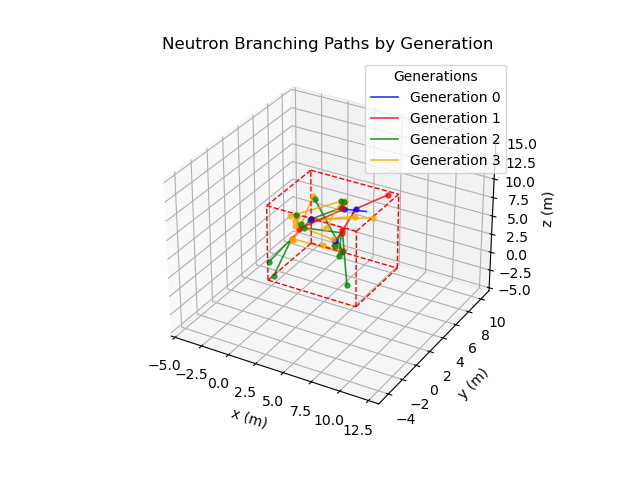

In [21]:
display(test.trajectories_graph)

**Figure 1.** A plot of the Neutron trajectories given the initial conditions of 4 starting neutrons, an $8 \times 6 \times 10$ meter box, and a maximal generation depth of 3. The mechanics of a singular simulation can be verified by observing the tree-like structure of the neutron paths. Each starting neutron produces a distinct tree of furthered neutrons, but neutrons that end beyond the limits of the box at any generation are untracked and all remaining trees are ended at the maximal generation. 

## Simulation Analysis

**Code Block Summary:** (`get_neutrons_in_each_generation`) Calculates the total number of neutrons in each generation by using the previous traversal method `traverse_tree` and building a histogram based on the generation index. Electrons that are lost are not considered in this count.

In [22]:
def get_neutrons_in_each_generation(tree: NeutronNode) -> np.array:
    """
    Counts the number of neutrons in each generation
    """
    counts = []

    for neutron, generation in traverse_tree(tree):
        if len(counts) <= generation:
            counts.append(0)
        if not neutron.lost:
            counts[generation] += 1

    return np.array(counts)

**Code Block Summary:** (`calculate_k_values`) Calculates the multiplication factor $k$ for each generation based on the list of neutrons in each generation for a given neutron tree using the formula $$k_{i} = \frac{n_{i}}{n_{i-1}}$$ where $n_i$ is the number of neutrons for generation $i$.

In [23]:
def calculate_k_values(trees: list[NeutronNode], max_generation: int):
    """
    For a list of neutron trees, calculates the total number 
    of neutrons in each generation, then returns an array of 
    k values (n_next / n_current) for each generation. 
    """
    counts = np.zeros(max_generation + 1)
    for tree in trees:
        tree_counts = get_neutrons_in_each_generation(tree)
        
        if tree_counts.size < max_generation + 1:
            tree_counts = np.pad(
                tree_counts, 
                (0, max_generation + 1 - tree_counts.size), 
                mode='constant', 
                constant_values=0
            )
        
        counts = np.add(counts, tree_counts)
    
    return np.divide(
        counts[1:],
        counts[:-1],
        out=np.zeros_like(counts[1:], dtype=float),
        where=counts[:-1] != 0
    )

**Code Block Summary:** (`simulate_all`) This code repeats a given simulation and calculates the mean, standard deviation, and standard error for $k$ alongside a bar plot of $k$ values for each generation obtained for given number of replications `m_reps`, and this graph can be used for validation against the produced $k$ values based on Monte-Carlo expectations.

In [24]:
@dataclass
class GenerationData:
    """
    Helper structure for storing k value 
    data and a histogram for each generation
    """
    k_values_raw:  np.array   = None
    k_mean:        np.float64 = np.nan
    k_std_dev:     np.float64 = np.nan
    k_std_err:     np.float64 = np.nan
    rel_k_std_err: np.float64 = np.nan
    
    histogram: Image = None

@dataclass
class MonteCarloResults:
    generations:     list[GenerationData] = None
    mean_k_values:   np.array = None
    k_value_uncerts: np.array = None
    k_value_plot:    Image    = None

In [25]:
def monte_carlo(dimensions: list[float], num_initial_neutrons: int, 
                num_replications: int,   max_generation: int, 
                plot: bool = False,      debug_print: bool = False):
    """
    Performs a Monte Carlo simulation by repeating a simulation of
    a set of initial conditions (`dimensions`, `num_initial_neutrons`, 
    `max_generation`) for `num_replications`.
    """
    # saves the data
    generation_data = [[] for _ in range(max_generation)]
    start_time = time.time()
    
    # index and interval for debugging
    interval = max(num_replications // 10, 1)
    
    # repeats the simulation for `num_replications`
    for i in range(num_replications):
        simulation_result = simulate(
            max_generation, 
            dimensions,   
            num_initial_neutrons, 
            plot=False
        ).result_trees
        
        # then append the results for each tree
        k_values = calculate_k_values(simulation_result, max_generation)
        for j, k in enumerate(k_values):
            generation_data[j].append(k)
                
        # Debug Print
        if debug_print and (i+1) % interval == 0:
            print(f'{((i+1) / num_replications) * 100:.0f}% - Replication {i+1}/{num_replications}')

    results = MonteCarloResults()
    results.generations     = []
    results.mean_k_values   = []
    results.k_value_uncerts = []
    
    for gen in range(len(generation_data)):
        data = GenerationData()
        
        data.k_values_raw = np.array(generation_data[gen])
        
        if data.k_values_raw.size > 0:
            data.k_mean    = np.mean(data.k_values_raw)
            data.k_std_dev = np.std(data.k_values_raw)
            data.k_std_err = data.k_std_dev / np.sqrt(data.k_values_raw.size)
            data.rel_k_std_err = data.k_std_err / data.k_mean \
                if data.k_mean > 0 else 0
            
            results.mean_k_values.append(data.k_mean)
            results.k_value_uncerts.append(data.k_std_err)
        
        if plot:
            plt.figure(figsize=(6, 4))

            # Histogram
            plt.hist(
                data.k_values_raw,
                bins=10,
                alpha=0.6,
                edgecolor="black",
                color=plt.get_cmap("viridis")(gen / max(1, max_generation-1))
            )

            # Vertical line for mean
            plt.axvline(data.k_mean, color='red', linestyle="--", linewidth=1.5)

            # Titles and labels
            plt.title(f"Generation {gen} to {gen+1}")
            plt.xlabel("k value")
            plt.ylabel("Frequency")
            plt.grid(alpha=0.3)

            # Text box with stats
            plt.text(
                0.95, 0.95,
                f"$\\bar{{k}}$={data.k_mean:.3f}\n±{data.k_std_err:.3f} (stderr)\nσ={data.k_std_dev:.3f}",
                verticalalignment='top',
                horizontalalignment='right',
                transform=plt.gca().transAxes,
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
            )

            plt.tight_layout()
            data.histogram = save_graph_and_close()
            
        results.generations.append(data)
    
    results.mean_k_values   = np.asarray(results.mean_k_values)
    results.k_value_uncerts = np.asarray(results.k_value_uncerts)
    
    if plot:
        plt.figure()
        plt.title('Mean Multiplication Rate by Generation')
        plt.errorbar(
            x=np.arange(results.mean_k_values.size),
            y=results.mean_k_values, 
            yerr=results.k_value_uncerts,
            fmt='bo--',
            label='k')
        plt.xticks(np.arange(results.mean_k_values.size))
        plt.xlabel('Generation')
        plt.ylabel('Multiplication Rate')
        results.k_value_plot = save_graph_and_close()
        
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    if debug_print:
        print(f"Executed in {int(elapsed_time)} s {int((elapsed_time - int(elapsed_time)) * 1000)} ms")
    
    return results

## Example Monte Carlo Test

**Code Block Summary:** This is an example Monte Carlo simulation for 3 generations (with a singular starting neutron), 250 initial neutrons, 300 replications, and a $10 \times 10 \times 10$ box.

In [26]:
example_mc_results = monte_carlo(
    dimensions            = (10,10,10), 
    num_initial_neutrons  = 250, 
    num_replications      = 300,
    max_generation        = 3,
    plot        = True,
    debug_print = True
)

10% - Replication 30/300
20% - Replication 60/300
30% - Replication 90/300
40% - Replication 120/300
50% - Replication 150/300
60% - Replication 180/300
70% - Replication 210/300
80% - Replication 240/300
90% - Replication 270/300
100% - Replication 300/300
Executed in 9 s 288 ms


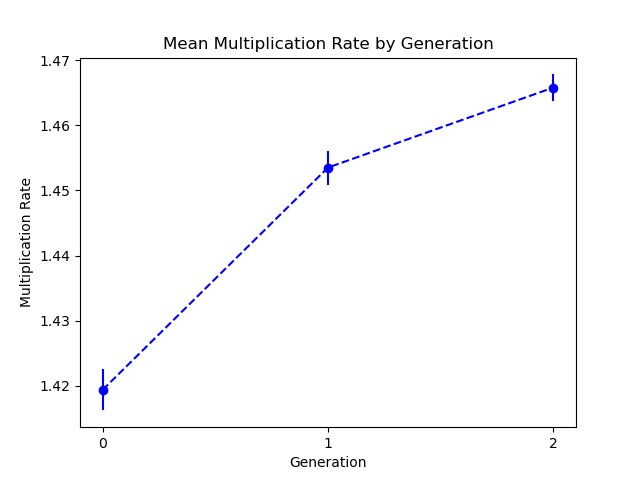

In [27]:
display(example_mc_results.k_value_plot)

**Figure 2.** For this box geometry, consisting of 250 initial neutrons and 300 replications over 3 generations for a 10 by 10 by 10 cubic box, the multiplication rate is initially growing (for the first few generations) as the spatial distribution of neutrons trends from the starting random distribution to the long-run stable distribution. This is because the starting random distribution is evenly distributed throughout the box, but neutrons closer to the centre are more likely to be replicated whereas neutrons closer to the edges are more likely to be lost, so a long-run stable distribution of neutrons would have more neutrons towards the centre and less neutrons towards the edges. This means that the initial random distribution must have a higher proportion of neutrons distributed towards the edges and a lower proportion of neutrons towards the centre, and this means that it must have a lower multiplication rates than toward the stable case. (All of this, however, assumes that the reactor's geometry is able to trend towards a stable multiplication rate, and does not apply for the unstable geometry which tend towards no replication whatsoever, and this will be addressed in further examples.)

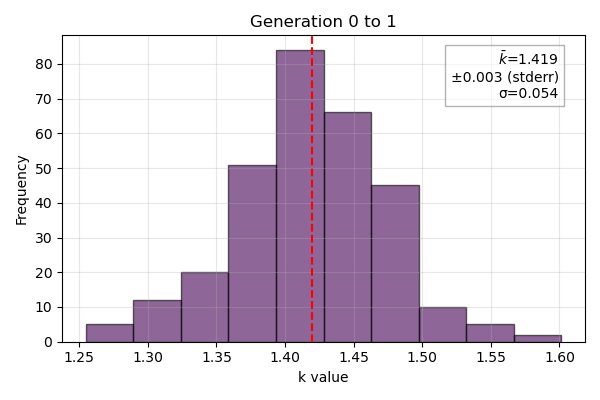

In [28]:
display(example_mc_results.generations[0].histogram)

**Figure 3.** The distribution of $k$-values produced by the Monte-Carlo simulation are a normal distribution centered around a particular value, and (as will be seen in comparison with figures 4 and 5) for the initial generation, there is a disproportionately higher amount of considerably lower multiplication rates (in the lowest decile) due to the aforementioned higher distribution of neutrons along the edges of the box.

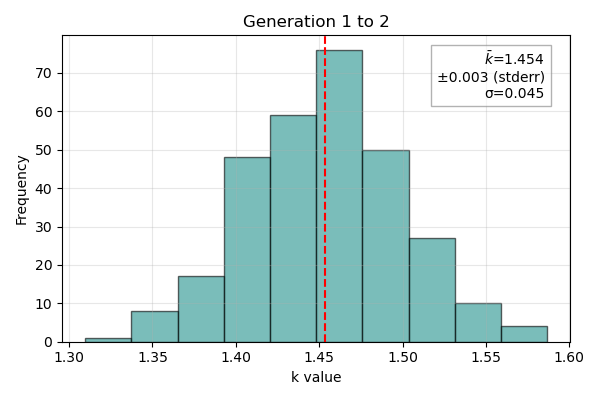

In [29]:
display(example_mc_results.generations[1].histogram)

**Figure 4.** In comparison with figure 3, the mean of the data is shifting further rightward (so the multiplication rate is increasing) and the standard deviation of the data is also decreasing.

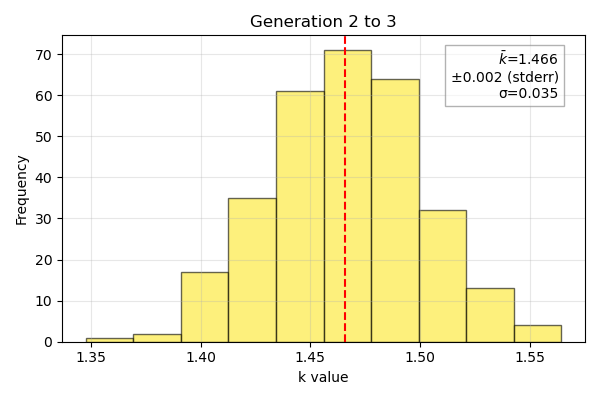

In [30]:
display(example_mc_results.generations[2].histogram)

**Figure 5.** The aforementioned pattern in Figure 4. is continued here, as the multiplication rate increases even more and the standard deviation continues to decrease.

# Determining the Minimal Replication Rate $m$ for Producing Accurate Aggregate Multiplication Rates

Before we determine the generation depth to work with, it'll be extremely important to consider the minimum number of replications to use to have accurate $k$-values. The way we can do this is based on how the relative standard error (the standard error divided by the multiplication rate) of a system changes based on our number of replications, and in particular, we'll want the relative standard error at whatever generation ends up being our minimal stable generation to be reasonably low. To do this, we can model the simulation for three generations as the number of generations required for the system to stabilize is likely higher, and systems before stabilization generally seem to have higher error in the multiplication rate than systems after stabilization, so if the error is minimized by three generations, then it should remain minimized once the system stabilizes.

**Side Note on the Number of Initial Neutrons:** Before determining the minimum-stable generation $g$ or the mimimum-accurate number of replications $m$, we need to set a number of initial neutrons to perform Monte-Carlo simulations with. It doesn't particularly matter what number we set this to, but this number needs to be good enough to pad out the generations and reduce the number of random-chance multiplication rates or progressions due to statistically unlikely distributions of neutrons that are caused from having very few starting neutrons. In short, I won't be doing a rigorous exploration into a good value for this. Rather, I'm just going to assume that having a neutron count greater than the volume (so a neutron or more per cubic metre) is a good benchmark, thus why I've gone with 250 starting neutrons for each simulation.

As a good base generation, let's just consider going as far as generation 5. Now, we'll want to pick a considerably nontrivial reactor geometry (more intuitively stable, so higher volumes and more even aspect ratios) and a trivial geometry to try and compare them.

To begin, let's consider a nearly-flat plane ($R=30$) with a small volume ($V=1$) as our unstable case:

In [31]:
min_rep_unstable_case = monte_carlo(
    dimensions            = calculate_dimensions(30, 1), 
    num_initial_neutrons  = 250, 
    num_replications      = 100,
    max_generation        = 5,
    plot                  = True,
    debug_print           = True
)

10% - Replication 10/100
20% - Replication 20/100
30% - Replication 30/100
40% - Replication 40/100
50% - Replication 50/100
60% - Replication 60/100
70% - Replication 70/100
80% - Replication 80/100
90% - Replication 90/100
100% - Replication 100/100
Executed in 1 s 614 ms


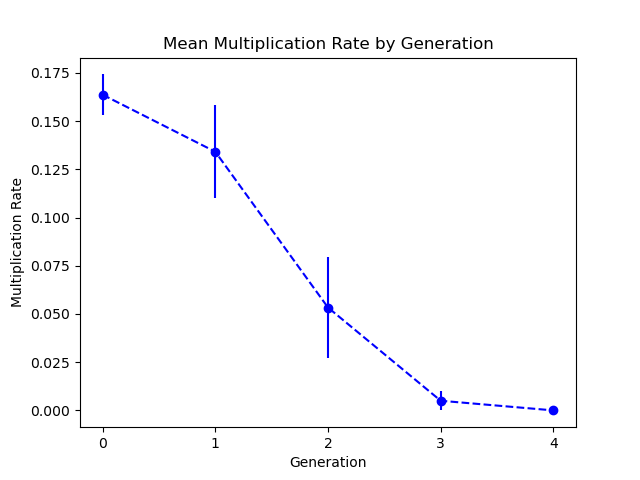

In [32]:
display(min_rep_unstable_case.k_value_plot)

**Figure 6.** The progression didn't even make it to 5 generations, so this geometry is trivially unstable, and there would be absolutely no uncertainty in the long-run $k$-value as being completely zero. Multiplication rates under this simulation have the ability to trend to zero whatsoever because of the limited number of neutrons that initially begin within the box. The number of generations for which neutrons are able to continue multiplying for a given simulation is a function of the number of neutrons that the system starts out with and the geometry of the box, and this length of time is shorter for more unstable geometries and longer for more stable geometries.

Now, let's consider a cube ($R=1$) with a large volume ($V=2000$ $m^3$) as our stable case:

In [33]:
min_rep_stable_case = monte_carlo(
    dimensions            = calculate_dimensions(1, 2000), 
    num_initial_neutrons  = 250, 
    num_replications      = 100,
    max_generation        = 5,
    plot                  = True,
    debug_print           = True
)

10% - Replication 10/100
20% - Replication 20/100
30% - Replication 30/100
40% - Replication 40/100
50% - Replication 50/100
60% - Replication 60/100
70% - Replication 70/100
80% - Replication 80/100
90% - Replication 90/100
100% - Replication 100/100
Executed in 9 s 110 ms


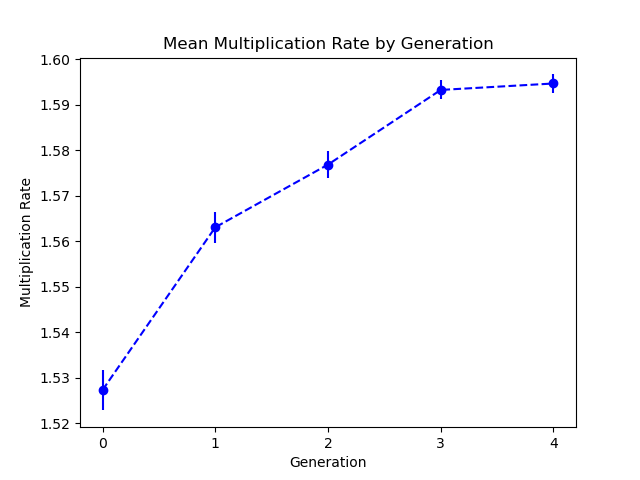

In [34]:
display(min_rep_stable_case.k_value_plot)

**Figure 7.** The standard error does seem to decrease with the number of successive generations. 

Based off of this, we can calculate the relative standard error for the last generation, as the relative standard error for whatever our final generation should be should be longer:

In [35]:
print(f'Relative Standard Error at Generation 4: {min_rep_stable_case.generations[4].rel_k_std_err * 100:.1f}%')

Relative Standard Error at Generation 4: 0.1%


As the relative standard error becomes about 0.2%, we can reasonably say that it's small enough for the simulation to be accurate at a replication rate of 100, so we'll just use $m=100$ replications for each point.

# Determining the Minimal Generation Depth $g$ for Producing Stable-System Multiplication Rates

As stated previously, each box geometry $(R,V)$ should eventually converge to some characteristic long-run multiplication rate after performing a number of generations of multiplications, with the purposes of the programs utilized in this exploration to produce the mapping from a box geometry to its characteristic multiplication rate
$$(R,V) \mapsto \overline{k}.$$
However, the exact number of generations required to converge (or, for a physical interpretation, for the reactor to reach a stable state) isn't a well-defined or easily calculable value. What can be reasonably assumed, however, is that different box geometries should alter in how many generations they take to converge by a predictable pattern, and then we can leverage this pattern to determine which geometry in our intended phase space requires the longest generation depth to converge.

To begin, we can reasonably assume that trivially unstable systems should converge to a characteristic multiplication rate of $k=0$, meaning that after some number of generations, the reaction stops completely (so the reactor is completely unstable). We can re-examine figures 6 and 7 to aid in this: the trivially-unstable geometry quickly converges to a zero multiplication rate, whereas the stable geometry is unable continues to grow towards its stable multiplication rate over the course of the simulation. Therefore, we'll only focus on stable systems for determining the minimal generation depth for producing a stable long-run value across all of our phase space.

In this simulation, I'm planning to explore a phase space of completely even aspect ratios at $R=1$ to skewed, more flat aspect ratios at $R=20$, and volumes from $V=1$ $m^3$ to $200$ $m^3$:
$$D = \{ 1 \le R \le 20 \} \otimes \{ 1 \le V \le 200 \},$$
so with this in mind, the most stable configuration should apriori be $R=1,V=200$. We can use this, pick some large generation number, then observe its $k$-progression graph to pick a point at which it becomes roughly stable.

To be absolutely certain that the data obtained at this point is correct, we can also use a much higher number of initial neutrons and number of replications to have as accurate of data as possible. Therefore, we'll use 1000 starting neutrons and 400 replications, as opposed to the 250 neutrons and 100 replications in other cases.

In [36]:
min_gen_case = monte_carlo(
    dimensions            = calculate_dimensions(1, 200), 
    num_initial_neutrons  = 250, 
    num_replications      = 100,
    max_generation        = 25,
    plot                  = True,
    debug_print           = True
)

10% - Replication 10/100
20% - Replication 20/100
30% - Replication 30/100
40% - Replication 40/100
50% - Replication 50/100
60% - Replication 60/100
70% - Replication 70/100
80% - Replication 80/100
90% - Replication 90/100
100% - Replication 100/100
Executed in 127 s 357 ms


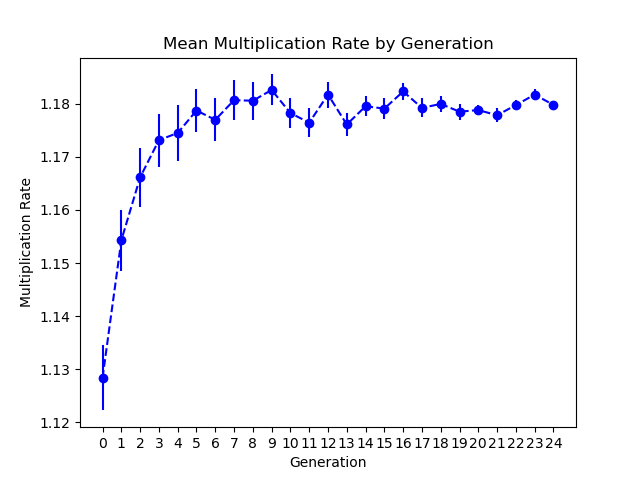

In [37]:
display(min_gen_case.k_value_plot)

**Figure 8.** It's difficult to exactly pinpoint where this system can be fully said to be stable, but we can be fairly confident that the system has reached long-term stability around generation 13 or 14, so to be absolutely sure, we can set the minimum-stable generation depth as $g=15$.

# Phase Investigation

**Code Block Summary:** This is the actual phase investigation, which performs `monte_carlo` for each of the box sizes produced given a domain of aspect ratios $(R_{min}, R_{max})$ and a domain of areas $(V_{min}, V_{max})$, alongside a number of starting neutrons, and number of replications per condition coordinate $(R,V)$. 

In [38]:
@dataclass
class ContourResults:
    contour_plot: Image = None
    uncertainty_contour_plot: Image = None

def generate_contour(aspect_ratio_range: tuple, volume_range: tuple, max_generation: int = 3,
                     num_initial_neutrons: int = 1, num_replications: int = 1,
                     debug_print: bool = False):
    """
    Explores the phase space of (R,V) and generates the overall contour for mean k across generations
    based on calling monte_carlo for each phase coordinate.
    """
    start_time = time.time()
    
    # Store some of the parameters to explore the contour
    contour_params = (max_generation, num_initial_neutrons, num_replications, aspect_ratio_range, volume_range)
    
    # Build the phase
    aspect_ratio_domain = np.linspace(*aspect_ratio_range)
    volume_domain = np.linspace(*volume_range)
    
    R, V = np.meshgrid(aspect_ratio_domain, volume_domain)
    K = np.zeros((aspect_ratio_domain.size, volume_domain.size), dtype=float)
    K_uncert = np.zeros_like(K)
    total_sims = aspect_ratio_domain.size * volume_domain.size
    
    # index and interval for debugging
    idx = 0
    interval = max(total_sims // 10, 1)
    
    # Iterate over the Phase
    for i, aspect_ratio in enumerate(aspect_ratio_domain):
        for j, volume in enumerate(volume_domain):
            idx += 1
            
            dimensions = calculate_dimensions(aspect_ratio, volume)
            simulation = monte_carlo(dimensions, num_initial_neutrons,
                                     num_replications, max_generation, plot=False)
            
            K[j,i] = simulation.mean_k_values[-1] if simulation.mean_k_values.size > 0 else 0
            K_uncert[j,i] = simulation.k_value_uncerts[-1] if simulation.k_value_uncerts.size > 0 else 0
            
            # Debug Print
            if debug_print and idx % interval == 0:
                print(f'{(idx / total_sims) * 100:.0f}% - Iteration {idx}/{total_sims}')
    
    # Plotting
    results = ContourResults()

    # Main Figure
    plt.figure()
    
    cp = plt.contourf(R, V, K, levels=20, cmap='viridis')
    plt.xlabel('Aspect Ratio $w/h$')
    plt.ylabel('Volume ($m^3$)')
    plt.title(f'Generation {max_generation-1} to {max_generation}: Mean $k$')
    plt.colorbar(cp, orientation='vertical', label='Mean Multiplication Rate')
    
    results.contour_plot = save_graph_and_close()
    
    # Relative Uncertainty Plot
    plt.figure()
    
    cp = plt.contourf(R, V, K_uncert * 100, levels=20, cmap='viridis')
    plt.xlabel('Aspect Ratio $w/h$')
    plt.ylabel('Volume ($m^3$)')
    plt.title(f'Generation {max_generation-1} to {max_generation}: Relative Uncertainty')
    plt.colorbar(cp, orientation='vertical', label='Relative Uncertainty Multiplication Rate (%)')
    
    results.uncertainty_contour_plot = save_graph_and_close()
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    if debug_print:
        print(f"Executed in {int(elapsed_time) // 60} m {int(elapsed_time) % 60} s {int((elapsed_time - int(elapsed_time)) * 1000)} ms")
    
    return results, contour_params

**Code Block Summary:** This is the exploration code for a range of 10 aspect ratios from $R=1$ to $R=20$ and 10 areas from $A=1$ to $A=200$, given 250 starting neutrons, 100 replications, and 15 generations. To lower the runtime, I'll only use a phase resolution of 400 points, with 20 slices for each dimension.

In [39]:
contour_results, contour_params = generate_contour(
    aspect_ratio_range   = (1, 20,  20), 
    volume_range         = (1, 200, 20),
    max_generation       = 15,
    num_initial_neutrons = 250, 
    num_replications     = 100,
    debug_print          = True
)

10% - Iteration 40/400
20% - Iteration 80/400
30% - Iteration 120/400
40% - Iteration 160/400
50% - Iteration 200/400
60% - Iteration 240/400
70% - Iteration 280/400
80% - Iteration 320/400
90% - Iteration 360/400
100% - Iteration 400/400
Executed in 19 m 28 s 504 ms


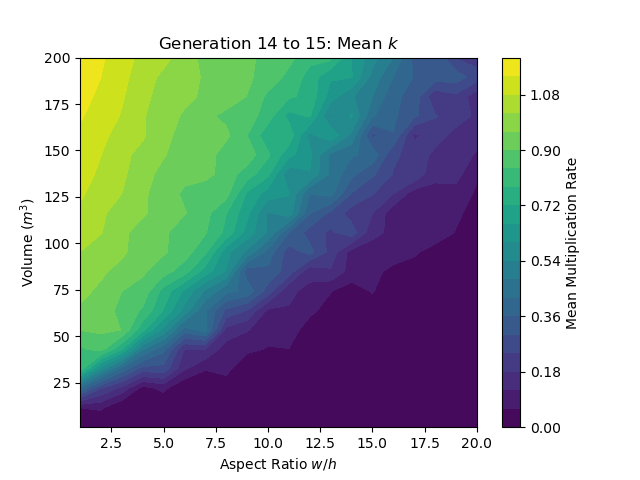

In [40]:
display(contour_results.contour_plot)

**Figure 9.** In terms of aspect ratio, the model clearly favors more cubic boxes around with aspect ratios of $1:1$ or $R=1$, and in terms of volume, higher volumes are much more favorable across the board. More skewed (unbalanced aspect ratios) and smaller volumes generally result in worse multiplication rates, with the worst multiplication rates (near 0, so no multiplications on average) are extremely skewed and very small boxes.

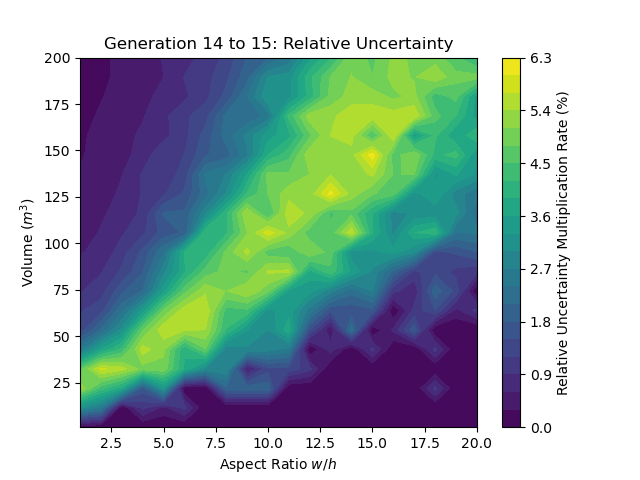

In [41]:
display(contour_results.uncertainty_contour_plot)

**Figure 10.** The random bouts of high or low multiplication rates that can be observed in figure 9 are best explained by examining the regions of highest uncertainty. We're least certain of the validity/accuracy of the measurements made along the main positive diagonal of the graph (from the bottom left to the top right), and this coincides with the region in figure 9 which shows the most random behavior.

## Phase Exploration: Cross-Sectional Analysis 

**Code Block Summary:** This code allows us to explore cross-sections of the phase to view patterns in how the multiplication rate changes with respect to a given parameter by holding the other parameters constant.

In [42]:
@dataclass
class CrossSectionData:
    k_value_plot: Image = None

def examine_cross_section(contour_params, aspect_ratio = None, volume=None, debug_print=False):
    """
    Performs the Monte-Carlo simulation along a given cross-section based on the parameter given.
    """
    if aspect_ratio is not None and volume is not None:
        raise ValueError('At least one parameter must be unspecified!')
    
    max_generation, num_initial_neutrons, num_replications, aspect_ratio_range, volume_range = contour_params
    
    start_time = time.time()
    
    aspect_ratio_domain = np.linspace(*aspect_ratio_range)
    volume_domain = np.linspace(*volume_range)
    
    x_label  = None
    x_values = []
    
    if aspect_ratio is not None: # Defined Aspect Ratio
        aspect_ratio_domain = np.array([aspect_ratio])
        x_label = 'Volume'
    else:
        volume_domain = np.array([volume])
        x_label = 'Aspect Ratio'
    
    total_sims = aspect_ratio_domain.size * volume_domain.size
    
    # index and interval for debugging
    idx = 0
    interval = max(total_sims // 10, 1)
    
    k_values = []
    k_uncert = []
    
    # Iterate over the Phase
    for i, aspect_ratio_i in enumerate(aspect_ratio_domain):
        for j, volume_i in enumerate(volume_domain):
            idx += 1
            
            dimensions = calculate_dimensions(aspect_ratio_i, volume_i)
            simulation = monte_carlo(dimensions, num_initial_neutrons,
                                     num_replications, max_generation, plot=False)
            
            if aspect_ratio is not None:
                x_values.append(volume_i)
            else:
                x_values.append(aspect_ratio_i)
            
            k_values.append(simulation.mean_k_values[-1])
            k_uncert.append(simulation.k_value_uncerts[-1])
            
            # Debug Print
            if debug_print and idx % interval == 0:
                print(f'{(idx / total_sims) * 100:.0f}% - Iteration {idx}/{total_sims}')
              
    results = CrossSectionData()
            
    plt.figure()
    plt.title(f'Mean Multiplication Rate vs. {x_label}')
    plt.errorbar(
        x=x_values,
        y=k_values, 
        yerr=k_uncert,
        fmt='bo--',
        label='k')
    plt.xlabel(x_label)
    plt.ylabel('Mean Multiplication Rate')
    results.k_value_plot = save_graph_and_close()
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    if debug_print:
        print(f"Executed in {int(elapsed_time) // 60} m {int(elapsed_time) % 60} s {int((elapsed_time - int(elapsed_time)) * 1000)} ms")
    
    return results

In order to try and get a very good picture of the relationship between how each individual parameter alters the multiplication rate, we can utilize a few cross-sectional analyses to help us, in the form of visualizing
$$f(R,V=V_0) \to \mathbf{k} \text{ or } f(R=R_0,V) \to \mathbf{k}.$$
To begin, we'll consider just the volume, holding the aspect ratio constant at $R_0=1$:

In [43]:
volume_cross_section = examine_cross_section(contour_params, aspect_ratio=1, debug_print=True)

10% - Iteration 2/20
20% - Iteration 4/20
30% - Iteration 6/20
40% - Iteration 8/20
50% - Iteration 10/20
60% - Iteration 12/20
70% - Iteration 14/20
80% - Iteration 16/20
90% - Iteration 18/20
100% - Iteration 20/20
Executed in 2 m 57 s 700 ms


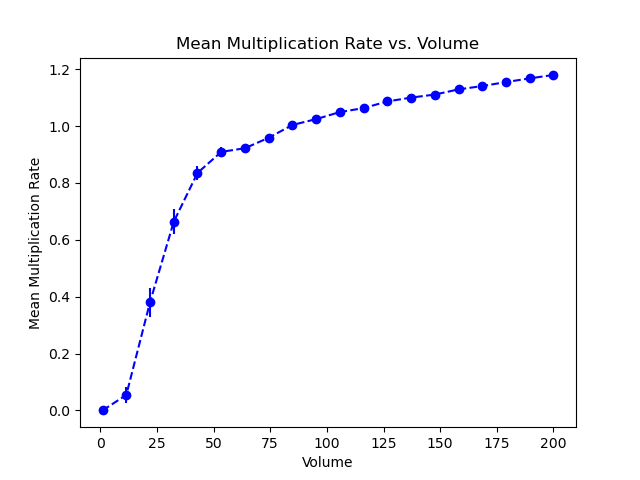

In [44]:
display(volume_cross_section.k_value_plot)

**Figure 11.** For the most stable aspect ratio (cubic), there's a positive relation between the volume and the mean multiplication rate with diminishing returns (levels out as the volume increases). Notably, the uncertainty also decreases significantly as volume is increased.

Now, we can consider the aspect ratio, holding the volume constant at $V_0=200$:

In [45]:
aspect_ratio_cross_section = examine_cross_section(contour_params, volume=200, debug_print=True)

10% - Iteration 2/20
20% - Iteration 4/20
30% - Iteration 6/20
40% - Iteration 8/20
50% - Iteration 10/20
60% - Iteration 12/20
70% - Iteration 14/20
80% - Iteration 16/20
90% - Iteration 18/20
100% - Iteration 20/20
Executed in 1 m 51 s 493 ms


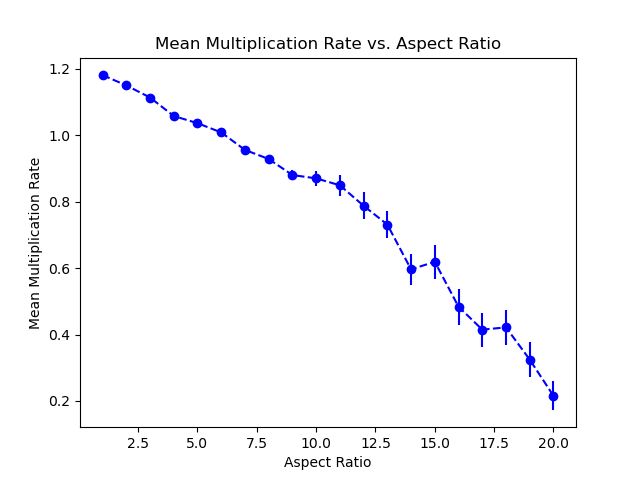

In [46]:
display(aspect_ratio_cross_section.k_value_plot)

**Figure 12.** As the aspect ratio is increased from an even ratio (cubic, most stable) to a highly skewed ratio, the mean multiplication rate decreases and the uncertainty greatly increases. 

## Phase Exploration: Edge Cases

**Code Block Summary:** This code will allow us to explore the phase by selecting individual coordinates, and that way, we can understand the results we are seeing. It works by taking the parameters we selected for our contour previously and performing the simulation for given coordinates $(R,V)$, and it returns an example simulation result alongside a full Monte Carlo simulation at that coordinate.

In [47]:
@dataclass
class PhaseCoordinateData:
    example_simulation: SimulationResult
    monte_carlo_result: list[GenerationData]

def examine_contour_coordinate(aspect_ratio, area, contour_params):
    """
    Performs the Monte-Carlo simulation for a phase coordinate
    (R,V) over again, and also provides an example simulation
    alongside the Monte-Carlo results so that we can observe
    what is going on at a certain coordinate.
    """
    max_generation, num_initial_neutrons, num_replications, _, _ = contour_params
    dimensions = calculate_dimensions(aspect_ratio, area)
    example_simulation = simulate(5, dimensions, 5, plot = True)
    
    # num_replications can be doubled to make this Monte-Carlo simulation more accurate
    monte_carlo_result = monte_carlo(dimensions, num_initial_neutrons, num_replications * 2, max_generation, plot=True)
    
    return PhaseCoordinateData(example_simulation, monte_carlo_result)

### Edge Case 1: Symmetric Aspect Ratio, Large Volume: $(R,V) = (1, 200)$

**Code Block Summary:** Now, we can explore the phase a bit to understand what is going on in the contour, and why it seems to favor wide boxes over tall boxes. We can begin with a phase coordinate that is clearly more representative of more stable geometry: $(R,V) \approx (1, 200)$ 

In [48]:
edge_case_1 = examine_contour_coordinate(1, 200, contour_params)

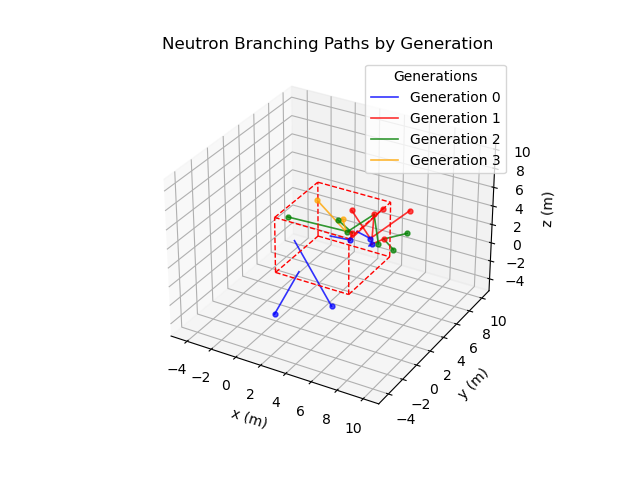

In [49]:
display(edge_case_1.example_simulation.trajectories_graph)

**Figure 13.** The sheer density and variety in color of the inside of this box shows that this model is capable of producing many neutrons across all tracked generations, so without a doubt, this simulation was extremely deep-reaching.

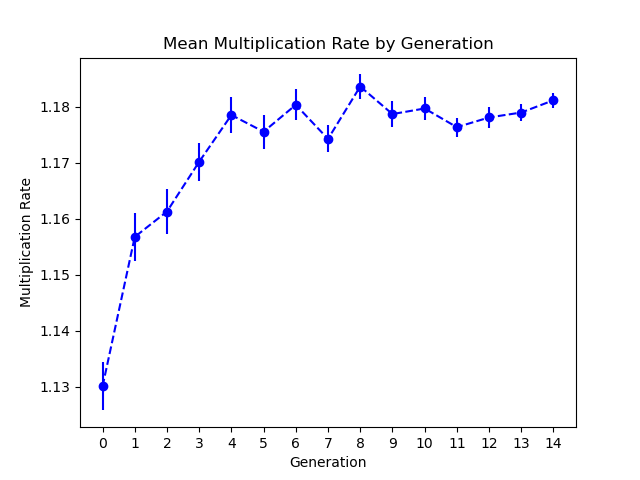

In [50]:
display(edge_case_1.monte_carlo_result.k_value_plot)

**Figure 14.** Here, we can see that the multiplication rate, once again, trends towards a stable, nonzero value. In particular, the multiplication rate is near but above $k=1$, so a physical interpretation is that the number of free neutrons within the reactor is increasing with respect to the number being lost, making this reactor supercritical.

### Edge Case 2: Skewed Aspect Ratio and Small Volume: $(R,V)=(20,1)$

In [51]:
edge_case_2 = examine_contour_coordinate(20, 1, contour_params)

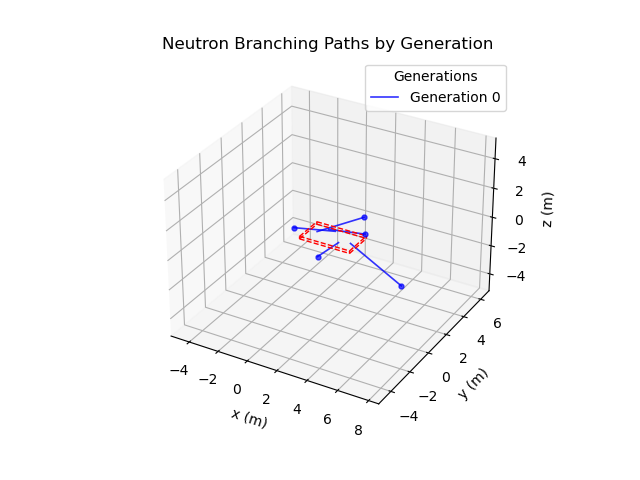

In [52]:
display(edge_case_2.example_simulation.trajectories_graph)

**Figure 15.** Here we can see that all of the neutrons in the starting generation were lost. This geometry is clearly unstable as the extremely small height caused all neutrons propagating vertically in any large way to be completely ejected from the box, and the simulation didn't progress past the very first generation. 

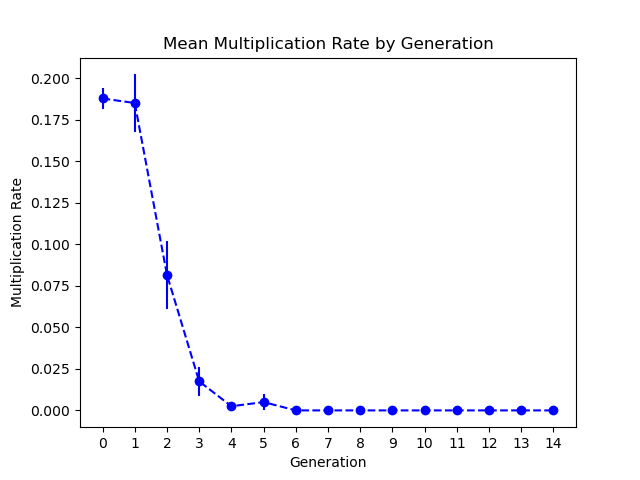

In [53]:
display(edge_case_2.monte_carlo_result.k_value_plot)

**Figure 16.** Again, as expected, this geometry was so unstable that its multiplication rate trends to zero quickly, so the physical interpretation from this is that this reactor geometry is subcritical.

### Edge Case 2: Medium-Skewed Aspect Ratio and Medium-Sized Volume (Center of the Phase Domain): $(R,V)=(10,100)$ and $R(R,V)=(17.5,175)$

Lastly, to try and understand what is going on along the region of high uncertainty, we can consider two points along the line $V=10R$: $(10,100)$ and $(17.5,175)$. First, we can consider $(10,100)$:

In [54]:
edge_case_3 = examine_contour_coordinate(10, 100, contour_params)

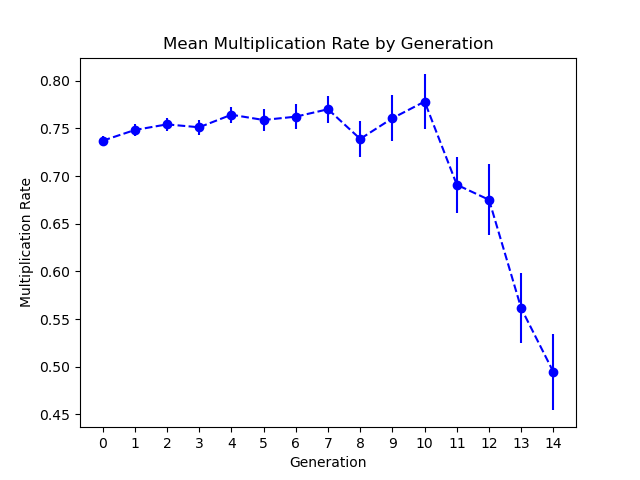

In [55]:
display(edge_case_3.monte_carlo_result.k_value_plot)

**Figure 17.** So, oddly, higher generation counts actually increase the uncertainty in the mean $k$ value at this point without obviously trending towards zero, which is the opposite of the trend seen for the most stable geometry (large cubes).

Now, we can repeat this with $(17.5,175)$ to see if this is a consistent pattern:

In [71]:
edge_case_4 = examine_contour_coordinate(17.5, 175, contour_params)

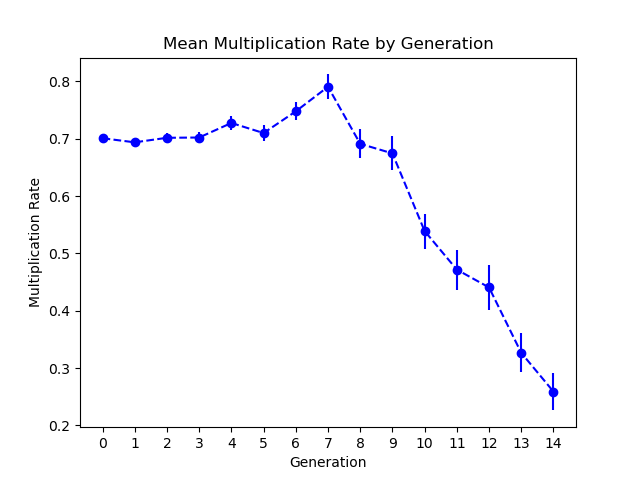

In [72]:
display(edge_case_4.monte_carlo_result.k_value_plot)

**Figure 18.** Again, we see the same trend: the uncertainty multiplication rate actually increases with respect to the generation for these points, but this geometry is still unstable and converges to a multiplication rate of zero.

## Summary of Findings

### Conclusions

Altogether, there is a clear preference in stable multiplication rates for even aspect ratios and larger volumes. Higher skew (aspect ratio $R$) and lower volumes decrease the multiplication rate, whereas lower skews and higher volumes increase the multiplication rate. For both cases, however, very stable systems or very unstable systems both trend to extremely certain measurements, and the uncertainty in the measurement is maximal for geometries that are only somewhat skewed and somewhat large in the middle of the phase (more "traditionally" rectangular geometries).

### Limitations

- This model doesn't consider length dependence whatsoever, and length is produced as a calculation between the width and height in order to keep the aspect-ratio 2-dimensional (and similarly, having a 2-dimensional contour).
- We assume that these reactors are able to approach long-term stability whatsoever, and that the trends we've pinpointed for determining the minimal-stable generational depth are thorough enough to accurately determine the stable multiplication rate for each reactor geometry. This exploration wasn't thoroughly considered for the points along the positive diagonal that result in seemingly unpredictable behavior, which questions if this assumption is truly correct.
- Only rectangular reactor geometries were considered, but in the real world, reactors are generally produced in cylindrical or spherical shapes.

### Future Work

This research begets the following questions:

1. How do the progression patterns in multiplication rate change for non-rectangular geometries, like spheres, cylinders, or polyhedrons?
2. What characteristics can be seen in the progression in multiplication rate for the maximally-uncertain geometries along the positive main diagonal of the contour?

## Bibliography

1. https://docs.python.org/3/library/dataclasses.html
2. https://docs.python.org/3/library/collections.html#collections.deque
3. https://pypi.org/project/pillow/
4. https://docs.python.org/3/library/io.html
5. https://cs110.students.cs.ubc.ca/reference/design-recipes.html#GenRec
6. https://docs.python.org/3/library/itertools.html
7. https://matplotlib.org/3.3.3/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html

# Appendix

## A. Validation Tasks

### A-1 Situational Intuition

Certain basic principles should apriori be true, and we can use this intuition to help us validate the results of this simulation. For example, an "infinite sized" box should lose absolutely no neutrons. We obviously cannot make an infinite box, but we can make a box much, much larger than the mean-free-path of a neutron. 

A cubic box with a volume of, say, $10^{10}$ $m^3$ volume should do the trick, and to keep the simulation simple, we can just model 8 generations (as every neutron will be modeled, so we want to keep this low such that we don't have to do too many computations). Then, we can just measure the number of neutrons that remain at the end, and if it is exactly $2^8$, then we know that the simulation works:

In [69]:
validation_1 = simulate(
    num_generations      = 8, 
    dimensions           = calculate_dimensions(1,1e6), 
    num_initial_neutrons = 1, 
    plot = False
)

In [70]:
valid_1_neutrons = get_neutrons_in_each_generation(validation_1.result_trees[0])
print(f'Neutron Count by Generation: {valid_1_neutrons}')
print(f'Base 2 Logarithm of Neutrons in Generation 8: {np.log2(valid_1_neutrons[-1])}')

Neutron Count by Generation: [  1   2   4   8  16  32  64 128 256]
Base 2 Logarithm of Neutrons in Generation 8: 8.0


So, therefore, we know that no neutrons were lost over the course of the simulation, so this absolutely worked. We can now try the next case, where we have a box that with a volume that is approximately zero. This should lose all of its neutrons absolutely, and shouldn't even progress past the first generation. For this simulation, we can approximate this by using a volume that is very close to zero but nonzero, like $V=10^{-6}$ $m^3$:

In [60]:
validation_2 = simulate(
    num_generations      = 8, 
    dimensions           = calculate_dimensions(1,1e-6), 
    num_initial_neutrons = 1, 
    plot = False
)

In [61]:
valid_2_neutrons = get_neutrons_in_each_generation(validation_2.result_trees[0])
print(f'Neutron Count by Generation: {valid_2_neutrons}')

Neutron Count by Generation: [0]


As we can see, the simulation entirely doesn't progress. The first, starting neutron isn't even counted as being successfully within the box as it immediately exits the box on its first movement.

Further, we also know that the same behavior of the neutrons being immediately lost should occur for any velocity with infinitesimal width (infinitely skewed ratio, or $R \to \infty$). We can test this, similarly, by pairing $R=10^{6}$ with $V=10^{6}$:

In [62]:
validation_3 = simulate(
    num_generations      = 8, 
    dimensions           = calculate_dimensions(1e6,1e6), 
    num_initial_neutrons = 1, 
    plot = False
)

In [63]:
valid_3_neutrons = get_neutrons_in_each_generation(validation_3.result_trees[0])
print(f'Neutron Count by Generation: {valid_3_neutrons}')

Neutron Count by Generation: [0]


As expected, even despite having the exact same volume as our "infinite volume" validation case, all of the neutrons are still lost due to having an infinitesimal width/infinite skew.

### A-2 Flat-Printing Trees

Flat-printing trees was utilized quite often throughout this project, and it has proven to be quite useful for understanding the behavior of a tree for a given simulation without the chaos of working with three-dimensional graphics. It's easy to quickly verify basic mechanics, like that the ending position of a parent is the starting position of all of its children, and I could quickly see which neutron trees were lost and when/why.

### A-3 Unit Tests

As usual, I've utilized unit testing quite thoroughly throughout this project, especially to verify the behavior of core functions. For more in-depth unit tests that required a lot of trivial testing (like testing array shapes and datatypes), I could get away with simply generating them with generative AI, but for very specific/core tests, I've made sure to manually write them.

In [64]:
def test_get_next_neutron_position(num_samples=100_000, tol=0.05):
    """
    Tests `get_next_neutron_position`
    """
    np.random.seed(0)
    current_position = np.zeros(3)
    
    positions = np.array([get_next_neutron_position(current_position) for _ in range(num_samples)])
    displacements = positions - current_position
    distances = np.linalg.norm(displacements, axis=1)
    
    # --- 1. Output shape check ---
    assert positions.shape == (num_samples, 3), "Output should be 3D positions"
    
    # --- 2. Mean displacement ≈ mean free path ---
    mean_distance = distances.mean()
    assert abs(mean_distance - MEAN_FREE_PATH) / MEAN_FREE_PATH < tol, \
        f"Mean distance {mean_distance:.2f} differs too much from expected {MEAN_FREE_PATH:.2f}"
    
    # --- 3. Direction uniformity check (mean of cos(theta) and sin(theta) near 0) ---
    directions = displacements / distances[:, None]
    mean_dir = np.mean(directions, axis=0)
    assert np.allclose(mean_dir, [0, 0, 0], atol=0.02), \
        f"Directions are not uniform (mean direction = {mean_dir})"
    
    # --- 4. Magnitude distribution sanity check (exponential shape) ---
    # Compare empirical mean to theoretical mean of exponential
    empirical_std = distances.std()
    theoretical_std = MEAN_FREE_PATH
    assert abs(empirical_std - theoretical_std) / theoretical_std < 0.1, \
        f"Standard deviation {empirical_std:.2f} should be near {theoretical_std:.2f}"
    
    print('Test Passed!')
    
test_get_next_neutron_position()

Test Passed!


In [65]:
def test_traverse_tree(debug_print: bool = False):
    if debug_print:
        for neutron, generation in traverse_tree(EXAMPLE_TREE):
            print(generation, neutron.start_pos, neutron.end_pos)
    
    assert len(list(traverse_tree(EXAMPLE_TREE))) == 5
    print("Test Passed!")
    
test_traverse_tree()

Test Passed!


In [66]:
def test_random_position_in_box():
    dim = (10,5,3)
    assert random_position_in_box(dim).size == 3

    pos = random_position_in_box(dim)
    assert bounded_in_dimensions(pos, dim)
    
    print('Test Passed!')
    
test_random_position_in_box()

Test Passed!


In [67]:
def test_is_outside_box():
    dim = (10,5)
    
    assert is_outside_box(random_position_in_box(dim), dim) == False
    assert is_outside_box(np.array([0,   0]), dim) == False
    assert is_outside_box(np.array([10,  5]), dim) == False
    assert is_outside_box(np.array([11,  5]), dim) == True
    assert is_outside_box(np.array([-1, -1]), dim) == True
    
    print('Test Passed!')
    
test_is_outside_box()

Test Passed!


In [68]:
import math

def test_generate_tree_structure():
    """Root should be a NeutronNode with valid positions."""
    root = generate_tree(3, (10, 10, 10))

    assert isinstance(root, NeutronNode), "Root must be NeutronNode"
    assert hasattr(root, "children"), "Root must have children list"

    assert len(root.start_pos) == 3, "Start position must be 3D"
    assert len(root.end_pos) == 3, "End position must be 3D"

    print("test_generate_tree_structure passed.")


def test_positions_validity():
    """
    Start must be inside the box; end may be inside or outside.
    """
    dims = (10, 10, 10)
    root = generate_tree(4, dims)

    assert bounded_in_dimensions(root.start_pos, dims), \
        "Initial position must be inside the box"

    print("test_positions_validity passed.")


def test_tree_depth():
    """
    Tree depth should not exceed num_generations.
    """
    dims = (10, 10, 10)
    gens = 4
    root = generate_tree(gens, dims)

    # BFS to compute max depth
    queue = [(root, 0)]
    max_depth = 0

    while queue:
        node, depth = queue.pop(0)
        max_depth = max(max_depth, depth)

        for child in node.children:
            queue.append((child, depth + 1))

    assert max_depth <= gens, "Tree depth exceeds num_generations"

    print("test_tree_depth passed.")


def test_lost_flag_correctness():
    """
    lost == True if and only if end_pos is outside box.
    """
    dims = (10, 10, 10)
    root = generate_tree(1, dims)

    expected = is_outside_box(root.end_pos, dims)
    assert root.lost == expected, "Lost flag does not match outside-box test"

    print("test_lost_flag_correctness passed.")


def test_multiple_generations_not_empty():
    """
    If num_generations > 0, root 
    should potentially have children.
    """
    dims = (10, 10, 10)
    root = generate_tree(3, dims)

    # Children may be zero if neutron is immediately lost,
    # but if not lost, we expect children
    if not root.lost:
        assert len(root.children) > 0, \
            "Root is not lost, but has no children!"

    print("test_multiple_generations_not_empty passed.")


def test_generate_tree():
    test_generate_tree_structure()
    test_positions_validity()
    test_tree_depth()
    test_lost_flag_correctness()
    test_multiple_generations_not_empty()
    print("\nALL TESTS PASSED!")


# Run them
test_generate_tree()

test_generate_tree_structure passed.
test_positions_validity passed.
test_tree_depth passed.
test_lost_flag_correctness passed.
test_multiple_generations_not_empty passed.

ALL TESTS PASSED!


## B. Reflection Questions

### B-1. Coding Approaches (A)

> How well did you apply and extend your coding knowledge in this project? Consider steps you took to make the code more efficient, readable and/or concise.

I had to go back and reference some programming theory from CPSC 110, a course I took last year, to treat the neutron-branching as a tree generation problem using generative recursion. This problem can be done in other ways, but a implementations of tree traversal and generation algorithms undoubtedly serves as the cleanest and simplest solution to this problem.

> Discuss any new-to-you coding techniques, functions or python packages that you learned how to use. 

I had to use three-dimensional plotting, which was definitely rough to implement (to say the least). I felt that, in this instance, no other kind of plot would have been effective to display the trajectories, as, for example, cross-sections leave out key dimensional information.

> Reflect on any unforeseen coding challenges you faced in completing this project.

Unlike past projects, functions in this project build upon each other a lot. If one function fails, then all future functions quickly fail. It became even more critical on this project than ever before that certain subroutines are guaranteed to work, and I struggled a bit on this project with maintaining that fault tolerance.

### B-2. Coding Approaches (B)

> Highlight an aspect of your code that you feel you did particularily well.

I'm particularly proud of my work on the function `traverse_tree` to simplify tree traversal, as this function allows for the generalization of the tree data structure with a much simpler interface.

> Discuss an aspect of your code that would benefit the most from further effort.

I feel somewhat unhappy with the code for generating the histograms for each generation, as this may be better as one multi-panel plot rather than separate plots, but I couldn't figure out how to dynamically generate this like I was able to on the contour plotting.

### B-3. Simulation Physics and Investigation (A)

> How well did you apply and extend your physical modelling and scientific investigation skills in this project? Consider the phase space you chose to explore and how throroughly you explored it. Consider how you translated physics into code and if appropriate any new physics you learned or developed a more thorough understanding of.

The nature of the phase space I've explored is in an attempt to study the relationship between the multiplication rate of the simulation as a function of the geometry of the bounding box, and I feel as though given the restrictions/research situation as I have framed it, I've been successful at considering the trends produced. I feel as though my investigation was sufficiently thorough, but my concern is that the research situation as I've framed it is a little trivial. Again, I made no consideration of length dependence (so this project is three-dimensional computationally but only two-dimensionally in parameters), and the results that I've produced are almost entirely trivial/intuitive. As such, I didn't use particularly complicated (or any new) physics on this project, but I feel quite happy with the physics I did use.

### B-4. Simulation Physics and Investigation (B)

> Highlight something you feel you did particularily well in terms of the context of your simulation, the physical modelling that you did or the investigation you performed. Discuss an aspect of these dimensions of your project that would benefit the most from further effort.

I believe my best section of physical modelling was in my calculation and plotting of three-dimensional electron trajectories (or, in other words, my full process for generating and displaying Neutron trees). This was undoubtedly my favorite part of my project, not only in terms of code-writing and mathematics but also in validating its success from seeing the visualization.

### B-5. Effectiveness of Your Communication

> Highlight something you feel you did particularily well in your visualizations or written communication. Discuss an aspect of your visualizations or written communication that would benefit the most from further effort.

I feel as though, again, that my 3-D plotting of the Neutron trajectories was quite good, but my visualization of the aspect ratio space is quite poor, because it really only shows the width dependence rather than the height dependence as well, as the range where $R > 1$ is obviously greater than the range where $0 \le R < 1$, and I couldn't figure out how to rectify this.

# Acknowledgements

I used ChatGPT quite a lot in writing this project, particularly for code generation (trivial tests, simple implementations, etc.). For example, due to my lack of knowledge in 3-D plotting, I provided ChatGPT with the following stub:
```python
def draw_3d_box(ax, origin, dimensions, edgecolor='red', linestyle='dashed', linewidth=1):
    """
    Draws a 3D wireframe box on a given 3D axes.
    """
    return
```
and then tried (and tweaked) its responses until I got a solution that seemed to work.